In [92]:
# -*- coding: utf-8 -*-
# -*- authors : Vincent Roduit, Filippo Quadri -*-
# -*- date : 2024-05-03 -*-
# -*- Last revision: 2024-05-03 -*-
# -*- python version : 3.9.18 -*-
# -*- Description: Notebook that summarize results-*-

# <center> EE - 451 Image Analysis and Pattern recognition </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Coin Challenge </center>
---

In [93]:
#Import libraries
import os
import numpy as np
import torch
import importlib
import skimage as sk
from skimage.color import rgb2hsv
import matplotlib.pyplot as plt
from typing import Callable
import cv2 as cv
from skimage.morphology import closing, opening, disk, remove_small_holes, remove_small_objects
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore")

In [94]:
#Import files
from data_classes.ref_data import refCoin
from data_classes.train_data import trainCoin
from data_classes.test_data import testCoin
import constants
from visualization import *
importlib.reload(constants)
from processing.process_func import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load different Datasets

In [95]:
ref_data = refCoin()

Loading data from pickle files


In [96]:
train_data = trainCoin()

Loading data from pickle files


In [97]:
test_data = testCoin()

Loading data from pickle files


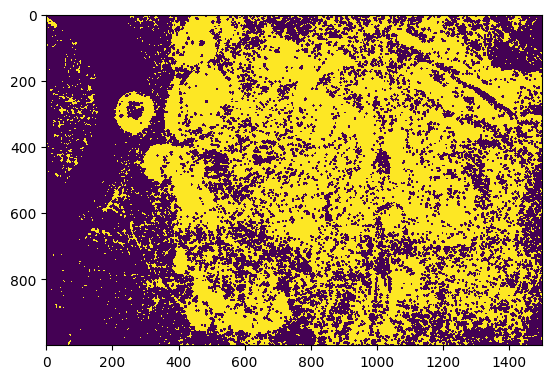

In [117]:
from processing.process_func import *
imgs = deepcopy(train_data.raw_data['noisy_bg'])
imgs_array = np.array(imgs)
path = './data/result'
imgs_mean = train_data.ref_bg['noisy_bg']
get_contours_noisy(imgs_array, imgs_mean,path)

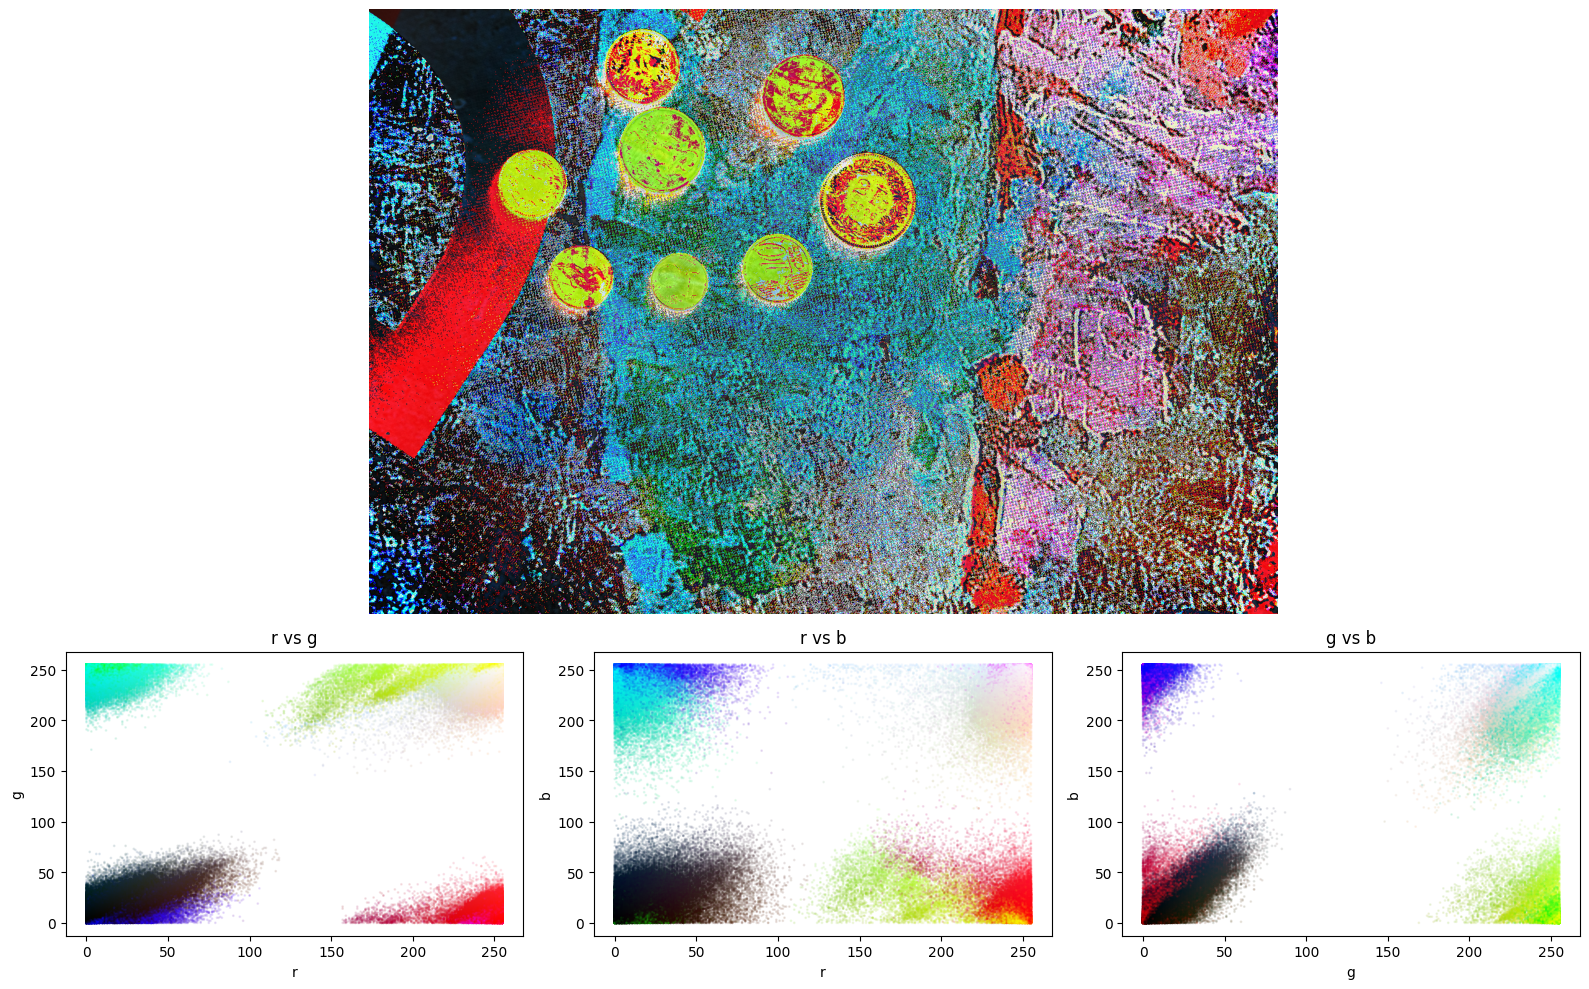

In [99]:
plot_colors_histo(imgs_array[4]-imgs_mean, extract_rgb_channels, ['r', 'g', 'b'])